In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import show
%matplotlib inline

import glob # to find all files in folder

import pycountry
import re # regex
from nltk.sentiment.util import *
import nltk as nl
from nltk.corpus import stopwords as nlstopw
import string
from matplotlib import cm


## Import data


In [2]:
folder = 'hillary-clinton-emails/'

In [3]:
emails = pd.read_csv(folder + 'Emails.csv', index_col='Id')
emails.head(5)

,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,MetadataDocumentClass,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
Id,,,,,,,,,,,,,,,,,,,,,
1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,HRC_Email_296,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,HRC_Email_296,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,HRC_Email_296,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,HRC_Email_296,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,HRC_Email_296,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


# Analyse Emails

In [4]:
emails.head()

,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,MetadataDocumentClass,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
Id,,,,,,,,,,,,,,,,,,,,,
1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,HRC_Email_296,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,HRC_Email_296,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,HRC_Email_296,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,HRC_Email_296,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,HRC_Email_296,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


The columns ExtractedBodyText is supposed to be the content of the mail but some of the mail have a ExtractedBodyText = NaN but the Rawtext seems to contains something

In [5]:
emails.columns

Index(['DocNumber', 'MetadataSubject', 'MetadataTo', 'MetadataFrom',
       'SenderPersonId', 'MetadataDateSent', 'MetadataDateReleased',
       'MetadataPdfLink', 'MetadataCaseNumber', 'MetadataDocumentClass',
       'ExtractedSubject', 'ExtractedTo', 'ExtractedFrom', 'ExtractedCc',
       'ExtractedDateSent', 'ExtractedCaseNumber', 'ExtractedDocNumber',
       'ExtractedDateReleased', 'ExtractedReleaseInPartOrFull',
       'ExtractedBodyText', 'RawText'],
      dtype='object')

In [6]:
print('Number of emails: ', len(emails))

Number of emails:  7945


In [7]:
bodyNaN = emails.ExtractedBodyText.isnull().sum()
print('Number of emails with ExtractedBodyText=NaN: {}, ({:.2f}%)'.format(emails.ExtractedBodyText.isnull().sum(), bodyNaN/ len(emails)))

Number of emails with ExtractedBodyText=NaN: 1203, (0.15%)


We could also use the subject since it is usually a summary of the mail

In [8]:
bodyNaN = emails.ExtractedSubject.isnull().sum()
print('Number of emails with ExtractedSubject=NaN: {}, ({:.2f}%)'.format(emails.ExtractedBodyText.isnull().sum(), bodyNaN/ len(emails)))

Number of emails with ExtractedSubject=NaN: 1203, (0.21%)


Now let's try to combine the subject and the body and drop the mail that have both subject= NaN and body = Nan

In [9]:
subBodyNan = emails[np.logical_and(emails.ExtractedBodyText.isnull(),emails.ExtractedSubject.isnull())]
print('Number of email where both subject and body is NaN: {}({:.2f})'.format(len(subBodyNan), len(subBodyNan)/ len(emails)))

Number of email where both subject and body is NaN: 368(0.05)


Well, that number is small enough to drop all email where both Extracted subject and Extracted body is NaN.

Let's drop them and create a new columns subjectBody that is the concatenation of the 2 columns ExtractedSubject and ExtractedBody. From now we will work with that columns

In [10]:
emails = emails[~ np.logical_and(emails.ExtractedBodyText.isnull(), emails.ExtractedSubject.isnull())]
len(emails)

7577

In [11]:
emails.ExtractedBodyText.fillna('',inplace=True)
emails.ExtractedSubject.fillna('',inplace=True)
emails['SubjectBody'] = emails.ExtractedBodyText + emails.ExtractedSubject
emails.SubjectBody.head()

Id
1                                              FW: Wow
2    B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...
3                                 ThxRe: Chris Stevens
4                      FVV: Cairo Condemnation - Final
5    H <hrod17@clintonemail.com>\nFriday, March 11,...
Name: SubjectBody, dtype: object

Last check to be sur that our columns of interest don't have anymore NaN

In [12]:
print('Number of NaN in columns SubjectBody: ' ,emails.SubjectBody.isnull().sum())

Number of NaN in columns SubjectBody:  0


# Keep only mail that mentions a country

Structure of a country in pycountry.countres

In [13]:
list(pycountry.countries)[0]

Country(alpha_2='AW', alpha_3='ABW', name='Aruba', numeric='533')

First we create a dataframe with one line by countries and we count for each countries its occurences in the mail.

Since a country can be reference in many way (Switzerland, switzerland, CH), we need to consider all the possible form. 

We may have a problem with word that have many meaning like US(country) and us (pronoun) so we can't just take all the country name in loer case and all the mail in lower case and just compare.

We first try to use that technique:
    1. the country name can appear either in lower case, with the first letter in uppercase or all in uppercase
    2. alpha_2 and alpha_3 are always used in uppercase
    
But we still have a lot of problem. Indeed a lot of mail contain sentences all in upper cas (see below):
       - SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER. STATE-SCB0045012
For example this sentence will match for Togo because of the TO and also for norway because of the NO. An other example is Andorra that appears in 55 mails thanks to AND

At first we also wanted to keep the upper case since it can be helpfull to do the sentiment analysis. Look at those 2 sentence and their corresponding score:
    - VADER is very smart, handsome, and funny.: compound: 0.8545, neg: 0.0, neu: 0.299, pos: 0.701,
    - VADER is VERY SMART, handsome, and FUNNY.: compound: 0.9227, neg: 0.0, neu: 0.246, pos: 0.754,
The score is not the same. But since we have a lot of information in Upper case and it nothing to do with sentiment, we will put all mails in lower case. And we will also remove the stopwords. 

We know that we remove the occurance of USA under 'us' but it will also remove the 'and', 'can', 'it',...





In [14]:
emails.SubjectBody.head(100).apply(print)

FW: Wow
B6
Thursday, March 3, 2011 9:45 PM
H: Latest How Syria is aiding Qaddafi and more... Sid
hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx
March 3, 2011
For: Hillary
ThxRe: Chris Stevens
FVV: Cairo Condemnation - Final
H <hrod17@clintonemail.com>
Friday, March 11, 2011 1:36 PM
Huma Abedin
Fw: H: Latest: How Syria is aiding Qaddafi and more... Sid
hrc memo syria aiding libya 030311.docx
Pis print.
Pis print.
-•-...-^
H < hrod17@clintonernailcom>
Wednesday, September 12, 2012 2:11 PM
°Russorv@state.gov'
Fw: Meet The Right-Wing Extremist Behind Anti-fvluslim Film That Sparked Deadly Riots
From [meat)
Sent: Wednesday, September 12, 2012 01:00 PM
To: 11
Subject: Meet The Right Wing Extremist Behind Anti-Muslim Film That Sparked Deadly Riots
htte/maxbiumenthal.com12012/09/meet-the-right-wing-extremist-behind-anti-musiim-tihn-that-sparked-
deadly-riots/
Sent from my Verizon Wireless 4G LTE DROID
U.S. Department of State
Case No. F-2015-04841
Doc No. C057

Id
1      None
2      None
3      None
4      None
5      None
6      None
7      None
8      None
9      None
10     None
11     None
12     None
13     None
14     None
15     None
16     None
17     None
18     None
19     None
20     None
21     None
22     None
23     None
24     None
25     None
26     None
27     None
28     None
29     None
30     None
       ... 
71     None
72     None
73     None
74     None
75     None
76     None
77     None
78     None
79     None
80     None
81     None
82     None
83     None
84     None
85     None
86     None
87     None
88     None
89     None
90     None
91     None
92     None
93     None
94     None
95     None
96     None
97     None
98     None
99     None
100    None
Name: SubjectBody, dtype: object

## Tokenize and remove stopwords

In [15]:

from gensim import corpora, models, utils
from nltk.corpus import stopwords
sw = stopwords.words('english') + ['re', 'fw', 'fvv', 'fwd']
sw = sw + ['pm', "a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount",  "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as",  "at", "back","be","became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thickv", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the"]

/Users/baptisteraemy/anaconda3/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [16]:
def fil(row):
    t = utils.simple_preprocess(row.SubjectBody)
    filt = list(filter(lambda x: x not in sw, t))
    return ' '.join(filt)
emails['SubjectBody'] = emails.apply(fil, axis=1)
emails.head(10)

,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,MetadataDocumentClass,...,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText,SubjectBody
Id,,,,,,,,,,,,,,,,,,,,,
1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,HRC_Email_296,...,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,,UNCLASSIFIED\nU.S. Department of State\nCase N...,wow
2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,HRC_Email_296,...,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...,thursday march latest syria aiding qaddafi sid...
3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,HRC_Email_296,...,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...,thxre chris stevens
4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,HRC_Email_296,...,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,,UNCLASSIFIED\nU.S. Department of State\nCase N...,cairo condemnation final
5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,HRC_Email_296,...,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...,hrod clintonemail com friday march huma abedin...
6,C05739559,MEET THE RIGHT-WING EXTREMIST BEHIND ANTI-MUSL...,Russorv@state.gov,H,80.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739559...,F-2015-04841,HRC_Email_296,...,NaN,NaN,"Wednesday, September 12, 2012 01:00 PM",F-2015-04841,C05739559,05/13/2015,RELEASE IN PART,Pis print.\n-•-...-^\nH < hrod17@clintonernail...,B6\nUNCLASSIFIED\nU.S. Department of State\nCa...,pis print hrod wednesday september russorv sta...
7,C05739560,"ANTI-MUSLIM FILM DIRECTOR IN HIDING, FOLLOWING...",H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739560...,F-2015-04841,HRC_Email_296,...,"Mills, Cheryl D <MillsCD@state.gov>",NaN,"Wednesday, September 12, 2012 4:00 PM",F-2015-04841,C05739560,05/13/2015,RELEASE IN FULL,,UNCLASSIFIED\nU.S. Department of State\nCase N...,anti muslim film director hiding following lib...
8,C05739561,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739561...,F-2015-04841,HRC_Email_296,...,NaN,NaN,NaN,F-2015-04841,C05739561,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.corn>\nFriday, March 11...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...,hrod clintonemail corn friday march huma abedi...
9,C05739562,SECRETARY'S REMARKS,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739562...,F-2015-04841,HRC_Email_296,...,"Sullivan, Jacob J <Sullivanli@stategov>",NaN,"W

In [17]:
countries = np.array([[country.name.lower(), country.alpha_2.lower(), country.alpha_3.lower()] for country in list(pycountry.countries)])
countries[:5]

array([['aruba', 'aw', 'abw'],
       ['afghanistan', 'af', 'afg'],
       ['angola', 'ao', 'ago'],
       ['anguilla', 'ai', 'aia'],
       ['åland islands', 'ax', 'ala']], 
      dtype='<U44')

In [18]:
countries.shape

(249, 3)

In [19]:
countries = pd.DataFrame(countries, columns=['Name', 'Alpha_2', 'Alpha_3'])
countries.head()



,Name,Alpha_2,Alpha_3
0,aruba,aw,abw
1,afghanistan,af,afg
2,angola,ao,ago
3,anguilla,ai,aia
4,åland islands,ax,ala


In [20]:
countries.shape

(249, 3)

In [21]:
countries.isin(['aruba']).any().any()

True

In [22]:
def check_country(row):
    return countries.isin(row.SubjectBody.split()).any().any()
    

In [23]:
emails_country = emails[emails.apply(check_country, axis=1)]
len(emails_country)


2208

# Sentiment analysis

We explain before our precessing. Now we will do the sentiment analysis only on the subject and the body
So we will only consider the subject and the body    

In [24]:
sentiments = pd.DataFrame(emails_country.SubjectBody)
sentiments.head()

,SubjectBody
Id,
2,thursday march latest syria aiding qaddafi sid...
5,hrod clintonemail com friday march huma abedin...
6,pis print hrod wednesday september russorv sta...
7,anti muslim film director hiding following lib...
8,hrod clintonemail corn friday march huma abedi...


In [25]:
sentiments.shape

(2208, 1)

## Analysis

We will do a sentiment analysis on each sentense and then compute a socre for each country

We will compare different module:
    - nltk.sentiment.vader that attribute a score to each sentence
    - liuhu that has a set of positive word and one of neg word. We count the positif word and neg word in each sentence and compute the mean

### Vader **(That part takes time)**

In [26]:
sentiments.head()


,SubjectBody
Id,
2,thursday march latest syria aiding qaddafi sid...
5,hrod clintonemail com friday march huma abedin...
6,pis print hrod wednesday september russorv sta...
7,anti muslim film director hiding following lib...
8,hrod clintonemail corn friday march huma abedi...


In [40]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
def sentiment_analysis(row):
    score = sid.polarity_scores(row)
    return pd.Series({'Pos': score['pos'], 'Neg': score['neg'], 'Compound_':score['compound'] })

sentiments = pd.concat([sentiments, sentiments.SubjectBody.apply(sentiment_analysis)], axis=1)

sentiments.to_csv('mailScore.csv')
sentiments.head()

,SubjectBody,Compound_,Neg,Pos
Id,,,,
2,thursday march latest syria aiding qaddafi sid...,0.0000,0.000,0.000
5,hrod clintonemail com friday march huma abedin...,0.0000,0.000,0.000
6,pis print hrod wednesday september russorv sta...,-0.9531,0.227,0.032
7,anti muslim film director hiding following lib...,-0.8225,0.589,0.000
8,hrod clintonemail corn friday march huma abedi...,0.0000,0.000,0.000


### Liuhu

In [27]:
from nltk.corpus import opinion_lexicon
sentimentsLihuh = pd.read_csv('mailScore.csv', index_col='Id')
#transform the array of positiv and negatif word in dict
dicPosNeg =  dict()
for word in opinion_lexicon.positive():
    dicPosNeg[word] = 1
    
for word in opinion_lexicon.negative():
    dicPosNeg[word] = -1   
    

def sentiment_liuhu(sentence):
    counter = []
    for word in sentence.split():
        value = dicPosNeg.get(word, -999)
        if value != -999:
            counter.append(value)
            
    if len(counter) == 0 :
        return pd.Series({'Sum_': int(0), 'Mean_': int(0) })
    return pd.Series({'Sum_': np.sum(counter), 'Mean_': np.mean(counter) })

sentimentsLihuh = pd.concat([sentimentsLihuh, sentimentsLihuh.SubjectBody.apply(sentiment_liuhu)], axis=1)

sentimentsLihuh.to_csv('mailScore2.csv')
sentimentsLihuh

,SubjectBody,Compound_,Neg,Pos,Mean_,Sum_
Id,,,,,,
2,thursday march latest syria aiding qaddafi sid...,0.0000,0.000,0.000,0.000000,0.0
5,hrod clintonemail com friday march huma abedin...,0.0000,0.000,0.000,0.000000,0.0
6,pis print hrod wednesday september russorv sta...,-0.9531,0.227,0.032,-0.230769,-3.0
7,anti muslim film director hiding following lib...,-0.8225,0.589,0.000,0.000000,0.0
8,hrod clintonemail corn friday march huma abedi...,0.0000,0.000,0.000,0.000000,0.0
10,wednesday september libya libya sept docx send...,0.0000,0.000,0.000,0.000000,0.0
11,fyi abz hb libya west bank gaza,0.2023,0.000,0.231,0.000000,0.0
12,wednesday september libya libya sept docx send...,0.0000,0.000,0.000,0.000000,0.0
14,anne marie slaughter sunday march jacob mills ...,0.9956,0.103,0.188,0.159420,11.0


## Aggregate by countries

We groupe by country and compute the mean of each score

In [28]:
sentiments = pd.read_csv('mailScore2.csv', index_col='Id')
sentiments.head()

,SubjectBody,Compound_,Neg,Pos,Mean_,Sum_
Id,,,,,,
2,thursday march latest syria aiding qaddafi sid...,0.0000,0.000,0.000,0.000000,0.0
5,hrod clintonemail com friday march huma abedin...,0.0000,0.000,0.000,0.000000,0.0
6,pis print hrod wednesday september russorv sta...,-0.9531,0.227,0.032,-0.230769,-3.0
7,anti muslim film director hiding following lib...,-0.8225,0.589,0.000,0.000000,0.0
8,hrod clintonemail corn friday march huma abedi...,0.0000,0.000,0.000,0.000000,0.0


In [30]:
def aggScoreByCountry(country):
    condition = sentiments.apply(lambda x: np.any(country.isin(x.SubjectBody.split())), axis=1)
    sent = sentiments[condition]
    if len(sent) == 0:
        print(country.Name, -999)
        return pd.Series({'Compound_':-999, 'Mean_':-999, 'Appearance': int(len(sent))})
    compound_ = np.mean(sent.Compound_)
    mean_ = np.mean(sent.Mean_)
    print(country.Name, compound_)
    return pd.Series({'Compound_': compound_, 'Mean_': mean_, 'Appearance': int(len(sent))})

countries = pd.concat([countries, countries.apply(lambda x: aggScoreByCountry(x), axis=1)],axis=1)
countries.to_csv('countriesScore.csv')

aruba -999
aruba -999
afghanistan 0.3221980392156861
angola 0.4339446153846152
anguilla 0.49756
åland islands 0.033333333333333326
albania 0.11405576923076924
andorra 0.3122958333333334
united arab emirates 0.20095
argentina 0.319656
armenia 0.293725641025641
american samoa -999
antarctica 0.10395000000000001
french southern territories -0.026650000000000007
antigua and barbuda 0.2629
australia 0.39453448275862074
austria -0.19118
azerbaijan 0.5881571428571429
burundi 0.2767
belgium -0.18862500000000001
benin 0.40291724137931034
bonaire, sint eustatius and saba -999
burkina faso -999
bangladesh 0.23368333333333333
bulgaria -999
bahrain 0.40132500000000004
bahamas 0.9961
bosnia and herzegovina 0.96235
saint barthélemy 0.9413
belarus 0.17
belize -999
bermuda -0.09228
bolivia, plurinational state of 0.9865
brazil 0.3331512195121952
barbados 0.15165
brunei darussalam -0.055454545454545486
bhutan 0.76915
bouvet island -999
botswana -999
central african republic 0.9949
canada 0.2580861111111

Drop all country that have a score of -999 (they never appear in the mails)

In [31]:
countries = countries[countries.Compound_ != -999]
len(countries)

207

It's a lot of country. We will also use a thresold for the appearance. We only keep mails that are mentioned in a minimum number of emails

In [32]:
minimum_appearance = 15
countries_min = countries[countries.Appearance >= minimum_appearance]
len(countries_min)

66

## Plot

We plot the 2 analysis. The first plot show an historgram with the **vador** score and in color the appearance in the mail.

In the second plot the histogram shows the **liuhu** score and in color the appearance in the mail

we only consider countries that are at least mention 15 times. Otherwise we end up with to much countries

/Users/baptisteraemy/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


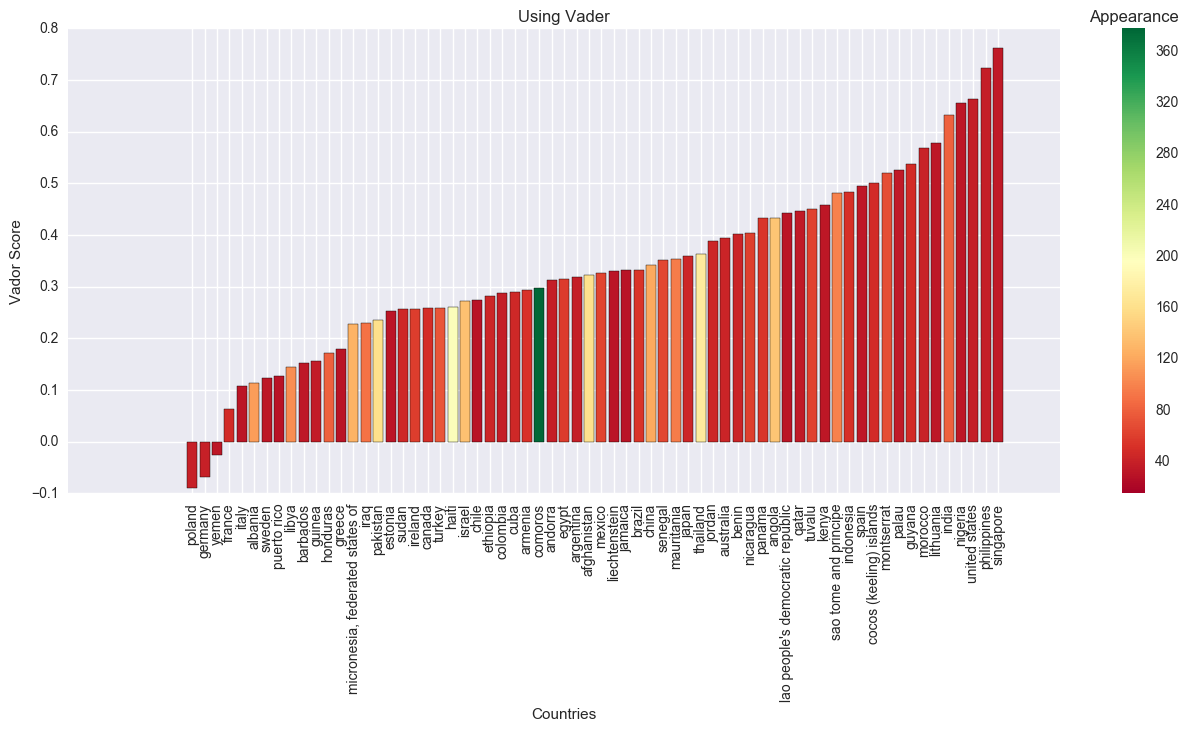

In [36]:
# Set up colors : red to green
countries_sorted = countries_min.sort(columns=['Compound_'])
plt.figure(figsize=(16, 6), dpi=80)


appearance = np.array(countries_sorted.Appearance)
colors = cm.RdYlGn((appearance / float(max(y))))
plot = plt.scatter(appearance, appearance, c=appearance, cmap = 'RdYlGn')
plt.clf()
colorBar = plt.colorbar(plot)
colorBar.ax.set_title("Appearance")


index = np.arange(len(countries_sorted))
bar_width = 0.95
plt.bar(range(countries_sorted.shape[0]), countries_sorted.Compound_, align='center', tick_label=countries_sorted.Name, color=colors)
plt.xticks(rotation=90, ha='center')
plt.title('Using Vader')
plt.xlabel('Countries')
plt.ylabel('Vador Score')


/Users/baptisteraemy/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


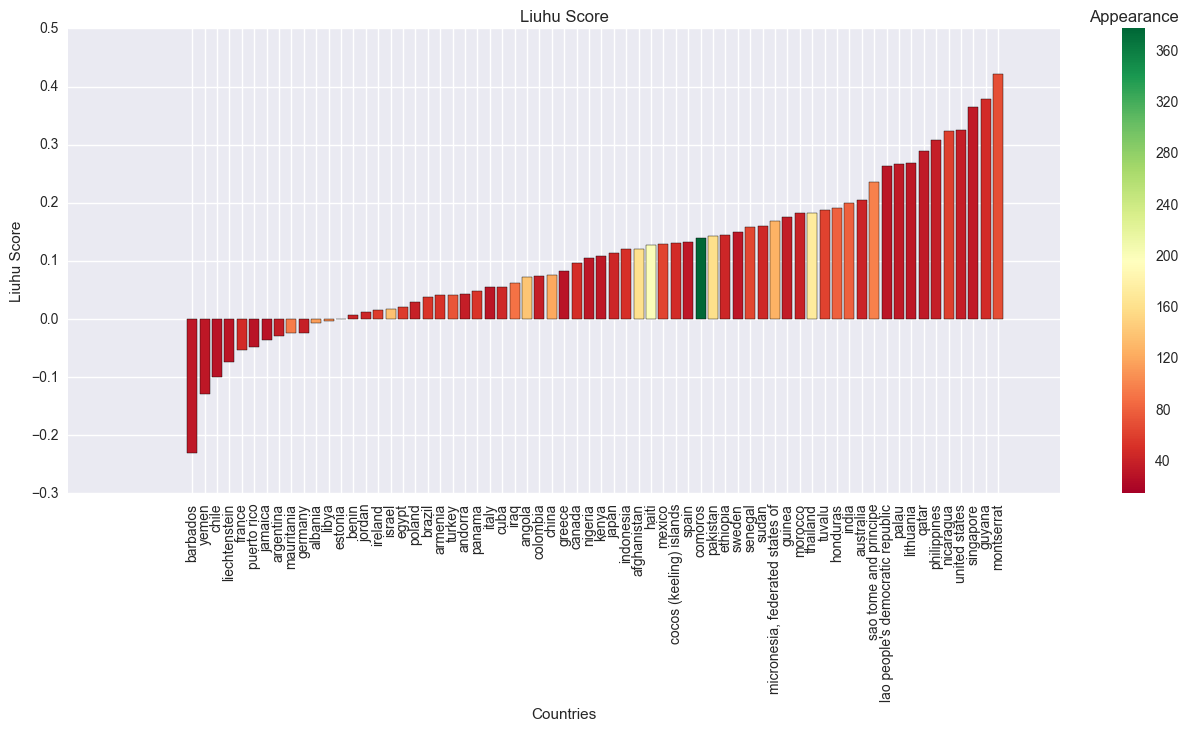

In [37]:
countries_sorted = countries_min.sort(columns=['Mean_'])

plt.figure(figsize=(16, 6), dpi=80)

appearance = np.array(countries_sorted.Appearance)
colors = cm.RdYlGn((appearance / float(max(y))))
plot = plt.scatter(appearance, appearance, c=appearance, cmap = 'RdYlGn')
plt.clf()
colorBar = plt.colorbar(plot)
colorBar.ax.set_title("Appearance")


index = np.arange(len(countries_sorted))
bar_width = 0.95
plt.bar(range(countries_sorted.shape[0]), countries_sorted.Mean_, align='center', tick_label=countries_sorted.Name, color=colors)
plt.xticks(rotation=90, ha='center')
plt.title('Liuhu Score')
plt.xlabel('Countries')
plt.ylabel('Liuhu Score')




We can see that our result are not very concluding. We coul expect to have USA with a high score and it doesn't appear in our graph. As explain before it's because of the us pronoum. 

One improvment is to use a Part-of-speech tagger and that way maybe we would be able to distinguish the country 'US' and the pronoun 'us'